In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/nejjar/scod-module

import scod
import torch
import numpy as np
from tqdm import trange

from matplotlib import pyplot as plt

/home/nejjar/scod-module


/home/nejjar/scod-module/scod/scod.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Create the dataset

In [2]:
class OneDDataset(torch.utils.data.Dataset):
    def __init__(self, N=100, fn=np.sin, split='train') -> None:
        super().__init__()
        if split == 'train':
            np.random.seed(1001)
        elif split == 'val':
            np.random.seed(2001)
        else:
            np.random.seed(3001)
        x = np.concatenate([-1.5 + np.random.rand(N//2), 0.5 + np.random.rand(N - N//2)])[:,None]
        y = fn(((x+3)/2)**2)
        noise_std = np.abs(0.05*x**2)
        noise = noise_std*np.random.randn(N,1)

        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y + noise).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,:])


In [3]:
# DNN mapping 2d input to 1d distribution parameter 
relu_model = torch.nn.Sequential(
    torch.nn.Linear(1, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1)
)

relu_dist_layer = scod.distributions.NormalMeanParamLayer()
joint_relu_model = torch.nn.Sequential(relu_model, relu_dist_layer)

In [4]:
tanh_model = torch.nn.Sequential(
    torch.nn.Linear(1, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 1)
)
tanh_dist_layer = scod.distributions.NormalMeanParamLayer()
joint_tanh_model = torch.nn.Sequential(tanh_model, tanh_dist_layer)

In [5]:
meanvar_model = torch.nn.Sequential(
    torch.nn.Linear(1, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2)
)
meanvar_dist_layer = scod.distributions.NormalMeanDiagVarParamLayer()
joint_meanvar_model = torch.nn.Sequential(meanvar_model, meanvar_dist_layer)

mean_loss=-1.255315: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.48it/s]


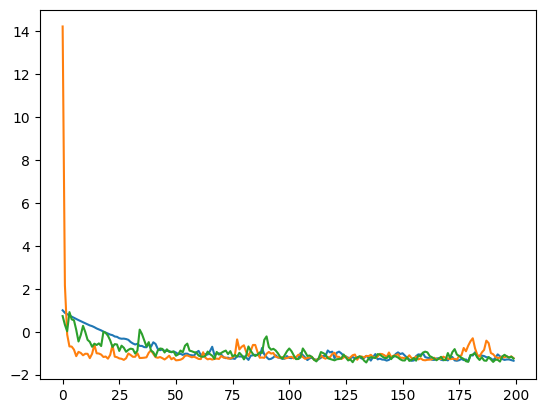

In [6]:
for model in [joint_relu_model, joint_tanh_model, joint_meanvar_model]:  
    dataset = OneDDataset()
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    losses = []
    t = trange(200)

    for epoch in t:
        epoch_loss = 0.
        for (inputs, targets) in train_dataloader:
            optimizer.zero_grad()
            
            dist = model(inputs)
            loss = -dist.log_prob(targets)

            mean_loss = loss.mean()

            mean_loss.backward()

            epoch_loss += mean_loss
            
            optimizer.step()
            
        epoch_loss /= len(train_dataloader)
        
        t.set_description("mean_loss=%02f"%epoch_loss.item())
        losses.append(epoch_loss.item())

    plt.plot(losses)

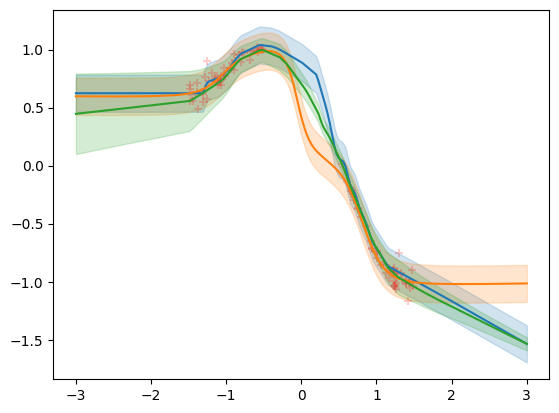

In [7]:
X = np.linspace(-3.,3.,200)
xx_tensor = torch.from_numpy(X).view(-1,1).float()

for j, model in enumerate([joint_relu_model, joint_tanh_model, joint_meanvar_model]):
    dist = model(xx_tensor)
    yhat = dist.mean.detach().cpu().numpy()[:,0]
    y_std = dist.stddev.detach().cpu().numpy()[:,0]

    plt.plot(X, yhat, color='C'+str(j))
    plt.fill_between(X, yhat - 1.92*y_std, yhat + 1.92*y_std, color='C'+str(j), alpha=0.2)


plt.scatter(dataset.X[:,0], dataset.Y, color='red', alpha=0.2, marker='+')

# plt.legend()

In [14]:
tanh_unc_model = scod.SCOD(tanh_model, args={
    'num_eigs': 10,
    'num_samples': 64,
    'sketch_type': 'srft',
})

relu_unc_model = scod.SCOD(relu_model, args={
    'num_eigs': 10,
    'num_samples': 64,
    'sketch_type': 'srft',
})

meanvar_unc_model = scod.SCOD(meanvar_model, args={
    'num_eigs': 10,
    'num_samples': 64,
    'sketch_type': 'srft',
})

Weight space dimension: 8.513e+03
Weight space dimension: 8.513e+03
Weight space dimension: 8.578e+03


In [15]:
tanh_unc_model.process_dataset(dataset, tanh_dist_layer)
relu_unc_model.process_dataset(dataset, relu_dist_layer)
meanvar_unc_model.process_dataset(dataset, meanvar_dist_layer)

computing basis
using T = 64


  0%|          | 0/100 [00:00<?, ?it/s]

computing basis
using T = 64


  0%|          | 0/100 [00:00<?, ?it/s]

computing basis
using T = 64


  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
settings = [
    {   
        'name': 'Tanh Activations',
        'model': tanh_unc_model,
        'dist_layer': tanh_dist_layer,
    },
    {   
        'name': 'ReLU Activations',
        'model': relu_unc_model,
        'dist_layer': relu_dist_layer,
    },
    {   
        'name': 'ReLU MeanVar output',
        'model': meanvar_unc_model,
        'dist_layer': meanvar_dist_layer,
    },
]

In [17]:
results = []
for setting in settings:
    scod_model = setting['model']
    
    z_mean, z_var = scod_model(xx_tensor)
    marg_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_var)
    z_var = z_var[:,:1]


    _, z_prior_var = scod_model(xx_tensor, use_prior=True)
    marg_prior_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_prior_var)
    z_prior_var = z_prior_var[:,:1]

    z_mean_dataset, _ = scod_model(dataset.X)
    z_mean_dataset = z_mean_dataset[:,:1]
    sq_err = (dataset.Y - z_mean_dataset)**2

    result = {
        'name': setting['name'],
        'z_vars': z_var.detach().cpu().numpy().reshape(X.shape),
        'total_var': marg_dist.variance.detach().cpu().numpy().reshape(X.shape),
        'prior_z_vars': z_prior_var.detach().cpu().numpy().reshape(X.shape),
        'total_prior_var': marg_prior_dist.variance.detach().cpu().numpy().reshape(X.shape),
        'sq_err' : sq_err.detach().cpu().numpy()
    }
    
    results.append(result)

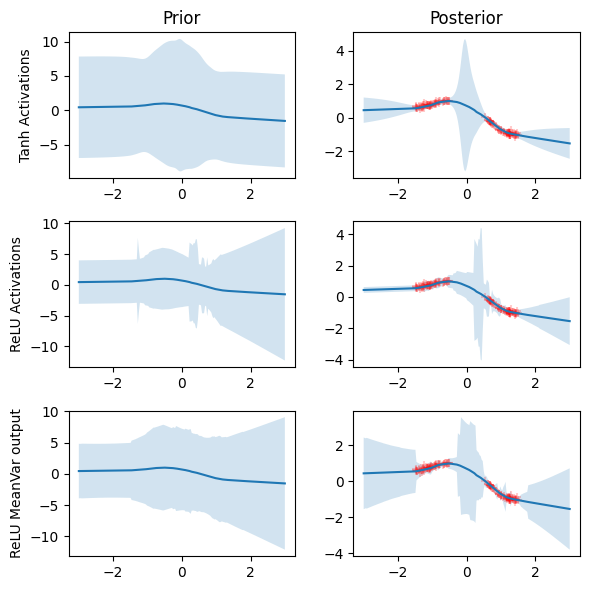

In [18]:
fig, axes = plt.subplots(len(results), 2, figsize=[6,6])

draw_y = True

for i, result in enumerate(results):
    std = np.sqrt(result['total_prior_var'])
    axes[i,0].fill_between(X, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
    axes[i,0].plot(X, draw_y*yhat)
    # axes[i,0].scatter(dataset.X[:,0], draw_y*dataset.Y)
    std = np.sqrt(result['total_var'])
    axes[i,1].fill_between(X, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
    axes[i,1].plot(X, draw_y*yhat)
    axes[i,1].scatter(dataset.X[:,0], draw_y*dataset.Y, marker='+', alpha=0.2, color='red')
    
    axes[i,0].set_ylabel(result['name'])

axes[0,0].set_title('Prior')
axes[0,1].set_title('Posterior')

plt.tight_layout()
plt.savefig("qualitative_1d.pdf")

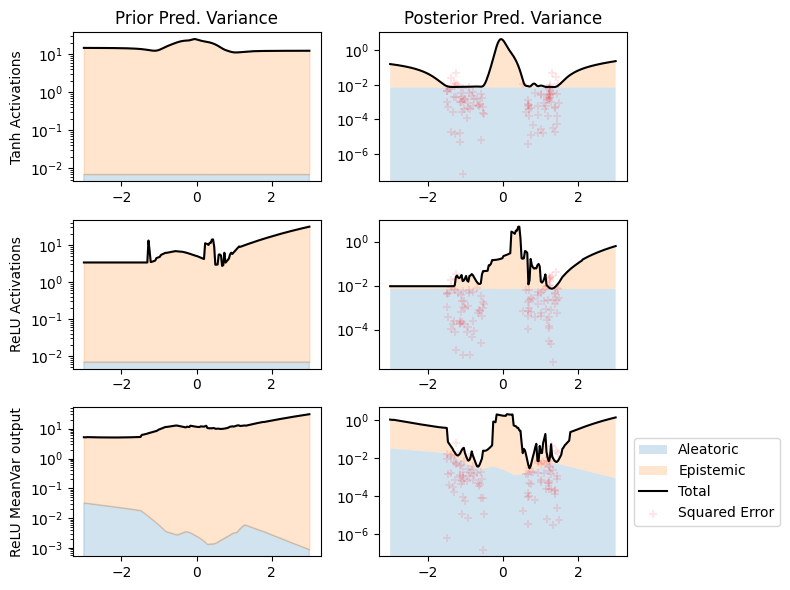

In [19]:
fig, axes = plt.subplots(len(results), 2, figsize=[8,6])

for i, result in enumerate(results):
    epistemic_prior = result['prior_z_vars']
    total_prior = result['total_prior_var'] 
    aleatoric_prior = total_prior - epistemic_prior
    axes[i,0].fill_between(X, aleatoric_prior, 0, alpha=0.2, color='C0', label="Aleatoric")
    # axes[i,0].plot(X, aleatoric_prior, color='C0')

    axes[i,0].fill_between(X, total_prior, aleatoric_prior, color='C1', alpha=0.2, label="Epistemic")
    axes[i,0].plot(X, total_prior, color='k', label="Total")    
    # axes[i,0].axhline(0, color='k')
    axes[i,0].set_yscale('log')


    epistemic = result['z_vars']
    total = result['total_var']
    aleatoric = total - epistemic
    axes[i,1].fill_between(X, aleatoric, 0, alpha=0.2, label="Aleatoric")
    # axes[i,1].plot(X, aleatoric, color='C0')
    axes[i,1].fill_between(X, total, aleatoric, alpha=0.2, label="Epistemic")
    axes[i,1].plot(X, total, color='k', label="Total")
    # axes[i,1].axhline(0, color='k')
    axes[i,1].set_yscale('log')

    # axes[i,1].axhline(np.mean(result['sq_err']), color='k', linestyle=':', label="Mean Squared Error")

    # ylims = axes[i,1].get_ylim()
    axes[i,1].scatter(dataset.X[:,0], result['sq_err'], alpha=0.1, marker="+", color='red', label="Squared Error")
    # axes[i,1].set_ylim(ylims)

    
    axes[i,0].set_ylabel(result['name'])

axes[0,0].set_title('Prior Pred. Variance')
axes[0,1].set_title('Posterior Pred. Variance')
axes[-1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.tight_layout()
# plt.savefig("qualitative_1d_var_only.pdf")